In [1]:
include("../../src/CoherentStructures.jl") #this is terrible but neccessary during development (?)

Main.CoherentStructures

In [2]:
using StreamMacros, Main.CoherentStructures
using Tensors, Arpack, JLD2, OrdinaryDiffEq
using Plots, UnicodePlots
using OrdinaryDiffEq
const ODE = OrdinaryDiffEq

OrdinaryDiffEq

In [3]:
JLD2.@load("Ocean_geostrophic_velocity.jld2");
UV = interpolateVF(Lon, Lat, Time, UT, VT);

In [4]:
# Parameters
grid_resolution        = 100
quadrature_order       = 1
ϵ                      = 1                # perturbation
selected_ev            = 1
t_initial              = minimum(Time)
t_end                  = t_initial+80     # parameter value corresponding to ϵ=0
scale                  = 10
solver_tolerance       = 1e-12
solver                 = OrdinaryDiffEq.BS5();

In [5]:
T(x, param) = flow(interp_rhs, x, [t_initial, t_end + scale*param], p=UV,
        tolerance=solver_tolerance,solver=solver)[end]

T (generic function with 1 method)

In [6]:
LL, UR = (-4.0, -34.0), (6.0, -28.0)
ctx, _ = regularTriangularGrid((grid_resolution, Integer(floor((UR[2] - LL[2])/(UR[1] - LL[1])*grid_resolution))), 
        LL, UR, quadrature_order = quadrature_order);
bdata = getHomDBCS(ctx, "all");

In [7]:
M = assembleMassMatrix(ctx, bdata=bdata);

In [8]:
# assemble K
DT₀(x) = linearized_transfer_function_autodiff(y -> T(y,0) , x)
A₀(x) = 0.5*(one(Tensor{2,2}) + dott(inv(DT₀(x))))
@time K = assembleStiffnessMatrix(ctx, A₀, bdata=bdata)
@time λs, us = eigs(K, M, which=:SM);

 34.372749 seconds (52.86 M allocations: 2.865 GiB, 3.09% gc time)
  3.388929 seconds (9.40 M allocations: 517.697 MiB, 5.32% gc time)


In [9]:
u₀ = us[:,selected_ev]
λ₀ = λs[selected_ev]
u₀ = u₀ ./ (u₀'*M*u₀);

In [10]:
DTϵ(x) = linearized_transfer_function_autodiff(y -> T(y,ϵ) , x)
Aϵ(x) = 0.5*(one(Tensor{2,2}) + dott(inv(DTϵ(x))))
@time Kϵ = assembleStiffnessMatrix(ctx, Aϵ, bdata=bdata)
λϵs, uϵs = eigs(Kϵ, M, which=:SM);

 21.544897 seconds (14.82 M allocations: 698.939 MiB, 0.92% gc time)


In [11]:
uϵ = uϵs[:,selected_ev]
λϵ = λϵs[selected_ev]
uϵ = uϵ ./ (uϵ'*M*uϵ);

In [12]:
DTminusϵ(x) = linearized_transfer_function_autodiff(y -> T(y,-ϵ) , x)
Aminusϵ(x) = 0.5*(one(Tensor{2,2}) + dott(inv(DTminusϵ(x))))
@time Kminusϵ = assembleStiffnessMatrix(ctx, Aminusϵ, bdata=bdata)
λminusϵs, uminusϵs = eigs(Kminusϵ, M, which=:SM);

 17.219214 seconds (14.81 M allocations: 698.823 MiB, 0.82% gc time)


In [13]:
uminusϵ = uminusϵs[:,selected_ev]
λminusϵ = λminusϵs[selected_ev]
uminusϵ = uminusϵ ./ (uminusϵ'*M*uminusϵ);

In [14]:
# assemble the linear response matrix L
Adot = x -> linear_response_tensor_autodiff(T, x, 0)
@time L = assembleStiffnessMatrix(ctx, Adot, bdata=bdata)
nothing

180.472989 seconds (43.97 M allocations: 2.010 GiB, 0.32% gc time)


In [15]:
# solve the system for the derivative u_dot
lhs = [K-λ₀*M   -M*u₀
        u₀'*M      0]
rhs = [-L*u₀    ;  0]

@time b = lhs \ rhs
u_dot = b[1:end-1]
λ_dot = b[end]

  1.783124 seconds (4.62 M allocations: 246.375 MiB, 12.77% gc time)


1.9960278618854191e9 + 0.0im

In [16]:
(λϵ - λminusϵ) / 2ϵ

-1.2230023692394414 + 0.0im

In [17]:
color = :balance;

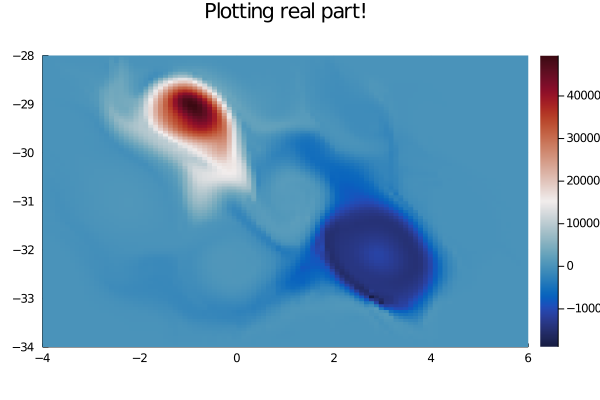

In [18]:
plot_u(ctx, u_dot,
        grid_resolution, grid_resolution, bdata=bdata, 
        colorbar=:left, color=color)#,clims=(-0.025,0.025))

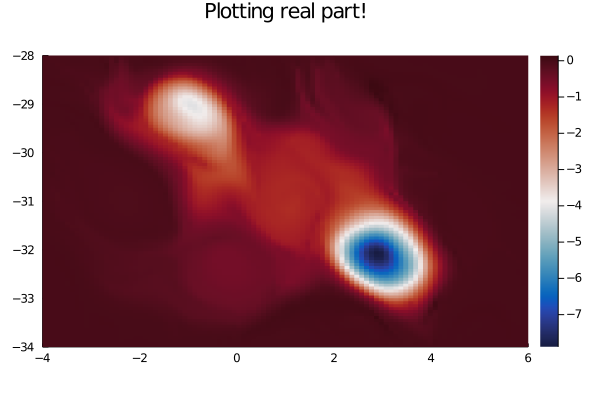

In [19]:
plot_u(ctx, u₀,
        grid_resolution, grid_resolution, bdata=bdata, 
        colorbar=:left, color=color)

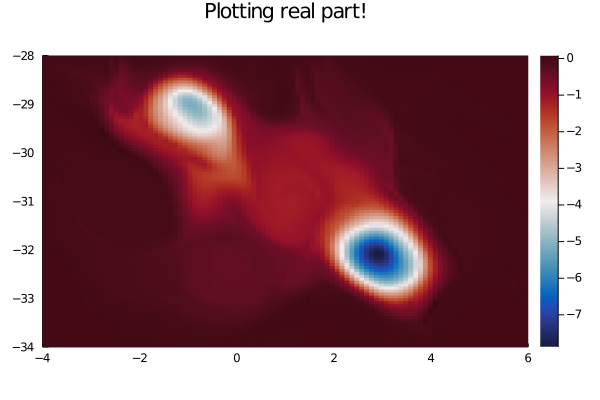

In [20]:
plot_u(ctx, uϵ,
        grid_resolution, grid_resolution, bdata=bdata, 
        colorbar=:left, color=color)

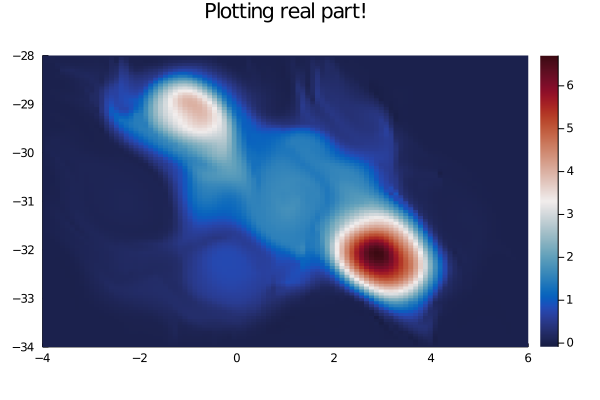

In [21]:
plot_u(ctx, uminusϵ,
        grid_resolution, grid_resolution, bdata=bdata, 
        colorbar=:left, color=color)

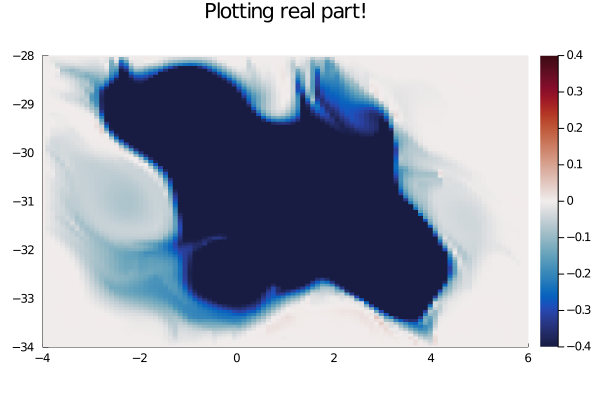

In [22]:
plot_u(ctx, (uϵ - uminusϵ) ./ (2*ϵ),
        grid_resolution, grid_resolution, bdata=bdata, 
        colorbar=:left, color=color, clims=(-0.4,0.4))